# Registration, Segmentation and cell-counting

## File path definition

In [53]:
subject_names = ["JW_NOSTIC2", 
                 "JW_NOSTIC3", 
                 "NOSTIC_VTA4", 
                 "NOSTIC_VTA_N6", 
                 "WT_VTA_N7", # channel
                 "NOSTIC_VTA_N8", 
                 "WT_VTA_N10", # channel
                 "NOSTIC_WT_N11", 
                 "JW_NOSTIC_VTA15", # channel
                 "JW_NOSTIC_VTA16", # channel
                ]

subject_NOT_USED = ["NOSTIC_VTA3", 
                    "JW_NOSTIC_VTA10",]

len(subject_names)

10

In [55]:
curSubject = subject_names[7] # 7
print(f"Current subject: {curSubject}")

Current subject: NOSTIC_WT_N11


## Downsample the images

In [56]:
# Image enhancement functions for brightening dark images
import cv2
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def gamma_correction(image, gamma=2.0):
    """
    Apply gamma correction to brighten dark images.
    gamma > 1.0 brightens the image (convex curve)
    gamma < 1.0 darkens the image (concave curve)
    """
    if isinstance(image, Image.Image):
        image_array = np.array(image)
    else:
        image_array = image
    
    # Normalize to 0-1 range
    normalized = image_array.astype(np.float32) / 255.0
    
    # Apply gamma correction (convex function for gamma > 1)
    corrected = np.power(normalized, 1.0 / gamma)
    
    # Convert back to 0-255 range
    result = (corrected * 255).astype(np.uint8)
    
    return result

def adaptive_histogram_equalization(image):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    for local contrast enhancement
    """
    if isinstance(image, Image.Image):
        image_array = np.array(image)
    else:
        image_array = image
    
    if len(image_array.shape) == 3:
        # Convert to grayscale for processing
        gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_array
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    return enhanced

def enhance_image_brightness(image, method='gamma', gamma=2.0, show_comparison=True):
    """
    Enhance image brightness using different methods
    
    Parameters:
    - image: PIL Image or numpy array
    - method: 'gamma', 'clahe', or 'both'
    - gamma: gamma value for correction (> 1.0 for brightening)
    - show_comparison: whether to display before/after comparison
    """
    if isinstance(image, Image.Image):
        original = np.array(image)
    else:
        original = image.copy()
    
    if method == 'gamma':
        enhanced = gamma_correction(original, gamma)
    elif method == 'clahe':
        enhanced = adaptive_histogram_equalization(original)
    elif method == 'both':
        # Apply gamma first, then CLAHE
        gamma_enhanced = gamma_correction(original, gamma)
        enhanced = adaptive_histogram_equalization(gamma_enhanced)
    else:
        raise ValueError("Method must be 'gamma', 'clahe', or 'both'")
    
    if show_comparison:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(original, cmap='gray' if len(original.shape) == 2 else None)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(enhanced, cmap='gray' if len(enhanced.shape) == 2 else None)
        plt.title(f'Enhanced ({method})')
        plt.axis('off')
        
        # Show histograms
        plt.subplot(1, 3, 3)
        if len(original.shape) == 2:
            plt.hist(original.flatten(), bins=50, alpha=0.7, label='Original', color='blue')
            plt.hist(enhanced.flatten(), bins=50, alpha=0.7, label='Enhanced', color='red')
        else:
            plt.hist(original.flatten(), bins=50, alpha=0.7, label='Original', color='blue')
            plt.hist(enhanced.flatten(), bins=50, alpha=0.7, label='Enhanced', color='red')
        plt.title('Histogram Comparison')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
    enhanced = Image.fromarray(enhanced) if isinstance(enhanced, np.ndarray) else enhanced
    return enhanced

# Test the enhancement on your current image
print("Testing image enhancement functions...")
print("Available methods: 'gamma' (convex curve), 'clahe' (adaptive), 'both' (combined)")

Testing image enhancement functions...
Available methods: 'gamma' (convex curve), 'clahe' (adaptive), 'both' (combined)


In [57]:
from PIL import Image, ImageOps
import numpy as np
import os
import glob

Image.MAX_IMAGE_PIXELS = 400000000  # or None to disable the check entirely

def _to_png_compatible(img: Image.Image, prefer_grayscale=True) -> Image.Image:
    # Normalize 16-bit or higher-depth images to 8-bit
    if img.mode in ("I;16", "I;16B", "I;16L", "I", "F"):
        arr = np.array(img)
        # robust normalization to 0..255
        a_min = float(arr.min())
        a_max = float(arr.max())
        if a_max > a_min:
            arr = (255.0 * (arr - a_min) / (a_max - a_min)).astype(np.uint8)
        else:
            arr = np.zeros_like(arr, dtype=np.uint8)
        return Image.fromarray(arr, mode="L")

    # Convert palette/CMYK/YCbCr to RGB
    if img.mode in ("P", "CMYK", "YCbCr"):
        img = img.convert("RGB")

    # Optionally force grayscale for DAPI
    if prefer_grayscale and img.mode == "RGB":
        img = ImageOps.grayscale(img)  # -> "L"
    elif img.mode == "RGBA":
        # drop alpha, then grayscale if preferred
        img = img.convert("RGB")
        if prefer_grayscale:
            img = ImageOps.grayscale(img)

    return img

def downsample_image_2Chnl(image_path, output_path, max_pixels=16000000*0.9):
    """
    Downsamples an image to ensure it is lower than the specified number of pixels.
    Saves as PNG for DeepSlice.
    """
    sliceName = os.path.basename(image_path)
    sliceName_png = os.path.splitext(sliceName)[0] + ".png"
    os.makedirs(output_path, exist_ok=True)  # ensure the target folder exists

    with Image.open(image_path) as img:
        # Use first frame if multi-frame (e.g., channels tiff)
        if getattr(img, "n_frames", 1) > 1:
            img.seek(1)

        # Make mode compatible with resize/save as PNG
        img = _to_png_compatible(img, prefer_grayscale=True)

        width, height = img.size
        total_pixels = width * height
        
        if total_pixels > max_pixels:
            scale = (max_pixels / total_pixels) ** 0.5
            new_size = (max(1, int(width * scale)), max(1, int(height * scale)))
            img = img.resize(new_size, Image.LANCZOS)
            img = enhance_image_brightness(img, method='both', gamma=2.0, show_comparison=False)
            print(f"Downsampled {image_path} to {new_size[0]}x{new_size[1]} pixels.")
        else:
            img = enhance_image_brightness(img, method='both', gamma=2.0, show_comparison=False)
            print(f"{image_path} is already below the maximum pixel limit.")

        img.save(os.path.join(output_path, sliceName_png))  # mode now PNG-safe

In [58]:
# ...existing code...
image_dir_raw = f"../VTA/{curSubject}/"
print(curSubject)
for image_path in glob.glob(os.path.join(image_dir_raw, "*.tiff")) \
                 + glob.glob(os.path.join(image_dir_raw, "*.tif")) \
                 + glob.glob(os.path.join(image_dir_raw, "*.png")):
    downsample_image_2Chnl(image_path, f"../Downsampled_mCherry/{curSubject}/")
# ...existing code...

NOSTIC_WT_N11


C:\Users\Wenji\AppData\Local\Temp\ipykernel_19264\2389376756.py:19: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode="L")


Downsampled ../VTA/NOSTIC_WT_N11\NOSTIC_WT_N11_1_GFP-Region 001-mTRITC.tiff to 4103x3509 pixels.
Downsampled ../VTA/NOSTIC_WT_N11\NOSTIC_WT_N11_1_GFP-Region 002-mTRITC.tiff to 4353x3307 pixels.
Downsampled ../VTA/NOSTIC_WT_N11\NOSTIC_WT_N11_1_GFP-Region 003-mTRITC.tiff to 4292x3354 pixels.
Downsampled ../VTA/NOSTIC_WT_N11\NOSTIC_WT_N11_1_GFP-Region 004-mTRITC.tiff to 4587x3138 pixels.
Downsampled ../VTA/NOSTIC_WT_N11\NOSTIC_WT_N11_1_GFP-Region 005-mTRITC.tiff to 4501x3198 pixels.
Downsampled ../VTA/NOSTIC_WT_N11\NOSTIC_WT_N11_2_GFP-Region 001-mTRITC.tiff to 4431x3249 pixels.
Downsampled ../VTA/NOSTIC_WT_N11\NOSTIC_WT_N11_2_GFP-Region 002-mTRITC.tiff to 4500x3199 pixels.
Downsampled ../VTA/NOSTIC_WT_N11\NOSTIC_WT_N11_2_GFP-Region 003-mTRITC.tiff to 4431x3249 pixels.
Downsampled ../VTA/NOSTIC_WT_N11\NOSTIC_WT_N11_2_GFP-Region 004-mTRITC.tiff to 4432x3248 pixels.
Downsampled ../VTA/NOSTIC_WT_N11\NOSTIC_WT_N11_3-Region 001-mTRITC.tiff to 4431x3249 pixels.
Downsampled ../VTA/NOSTIC_WT_N11\N

# Convert mCherry channel to PNG

In [59]:
import PIL.Image as Image
import numpy as np
import os, glob

def convert_mCherry_to_png(image_path, output_path):
    """
    Convert mCherry channel images to PNG format.
    """
    sliceName = os.path.basename(image_path)
    sliceName_png = os.path.splitext(sliceName)[0] + ".png"
    os.makedirs(output_path, exist_ok=True)  # ensure the target folder exists
    
    with Image.open(image_path) as img:
        # Use second frame if multi-frame (e.g., channels tiff)
        if getattr(img, "n_frames", 1) > 1:
            img.seek(1)
            
        # Convert to png
        png_img = _to_png_compatible(img, prefer_grayscale=True)
        # Save the mCherry channel as a PNG
        print(f"Saving mCherry channel for {sliceName} to {os.path.join(output_path, sliceName_png)}")
        png_img.save(os.path.join(output_path, sliceName_png))

In [60]:
# Convert mCherry channel images to PNG format.
image_dir_raw = f"../VTA/{curSubject}/"
for image_path in glob.glob(os.path.join(image_dir_raw, "*.tiff")) \
                 + glob.glob(os.path.join(image_dir_raw, "*.tif")) \
                 + glob.glob(os.path.join(image_dir_raw, "*.png")):
    convert_mCherry_to_png(image_path, f"../mCherry_PNG/{curSubject}/")

C:\Users\Wenji\AppData\Local\Temp\ipykernel_19264\2389376756.py:19: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode="L")


Saving mCherry channel for NOSTIC_WT_N11_1_GFP-Region 001-mTRITC.tiff to ../mCherry_PNG/NOSTIC_WT_N11/NOSTIC_WT_N11_1_GFP-Region 001-mTRITC.png
Saving mCherry channel for NOSTIC_WT_N11_1_GFP-Region 002-mTRITC.tiff to ../mCherry_PNG/NOSTIC_WT_N11/NOSTIC_WT_N11_1_GFP-Region 002-mTRITC.png
Saving mCherry channel for NOSTIC_WT_N11_1_GFP-Region 003-mTRITC.tiff to ../mCherry_PNG/NOSTIC_WT_N11/NOSTIC_WT_N11_1_GFP-Region 003-mTRITC.png
Saving mCherry channel for NOSTIC_WT_N11_1_GFP-Region 004-mTRITC.tiff to ../mCherry_PNG/NOSTIC_WT_N11/NOSTIC_WT_N11_1_GFP-Region 004-mTRITC.png
Saving mCherry channel for NOSTIC_WT_N11_1_GFP-Region 005-mTRITC.tiff to ../mCherry_PNG/NOSTIC_WT_N11/NOSTIC_WT_N11_1_GFP-Region 005-mTRITC.png
Saving mCherry channel for NOSTIC_WT_N11_2_GFP-Region 001-mTRITC.tiff to ../mCherry_PNG/NOSTIC_WT_N11/NOSTIC_WT_N11_2_GFP-Region 001-mTRITC.png
Saving mCherry channel for NOSTIC_WT_N11_2_GFP-Region 002-mTRITC.tiff to ../mCherry_PNG/NOSTIC_WT_N11/NOSTIC_WT_N11_2_GFP-Region 002-mTR

In [61]:
# # Test enhancement on one of your images
# test_image_path = f"../VTA/{curSubject}/"
# test_files = glob.glob(os.path.join(test_image_path, "*.tiff")) + glob.glob(os.path.join(test_image_path, "*.tif"))

# if test_files:
#     # Load the first image for testing
#     with Image.open(test_files[0]) as img:
#         if getattr(img, "n_frames", 1) > 1:
#             img.seek(1)  # Use mCherry channel
#         test_img = np.array(img)
    
#     print(f"Testing enhancement on: {os.path.basename(test_files[0])}")
#     print(f"Image shape: {test_img.shape}")
#     print(f"Pixel value range: {test_img.min()} - {test_img.max()}")
    
#     # Try different gamma values
#     for gamma_val in [1.5, 2.0, 2.5]:
#         print(f"\n=== Gamma correction with γ = {gamma_val} ===")
#         enhanced = enhance_image_brightness(test_img, method='gamma', gamma=gamma_val, show_comparison=True)
# else:
#     print("No TIFF files found for testing. Make sure your data path is correct.")

# Resgister the slices to atlas using DeepSlice

In [1]:
import tensorflow as tf
print(tf.__version__)

ImportError: Traceback (most recent call last):
  File "c:\Python\Python312\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [4]:
subject_names = ["JW_NOSTIC2", 
                 "JW_NOSTIC3", 
                 "NOSTIC_VTA4", 
                 "NOSTIC_VTA_N6", 
                 "WT_VTA_N7", # channel
                 "NOSTIC_VTA_N8", 
                 "WT_VTA_N10", # channel
                 "NOSTIC_WT_N11", 
                 "JW_NOSTIC_VTA15", # channel
                 "JW_NOSTIC_VTA16", # channel
                ]

subject_NOT_USED = ["NOSTIC_VTA3", 
                    "JW_NOSTIC_VTA10",]

print(len(subject_names))

curSubject = subject_names[4] # 7
print(f"Current subject: {curSubject}")

10
Current subject: WT_VTA_N7


In [7]:
# ...existing code...
# filepath: d:\Histology_analysis\NOSTIC_VTA_NA_dataset\Scripts\Histology_To_atlas_test.ipynb
# Define the folder with your PNGs

import os
folderpath = f"../Downsampled_mCherry/{curSubject}/"

from DeepSlice import DSModel
Model = DSModel('rat')

Model.predict(folderpath, ensemble=True, section_numbers=False)
Model.adjust_angles(ML=0, DV=0)  # Adjust these values as needed
Model.propagate_angles()
Model.save_predictions(os.path.join(folderpath, "MyResults"))

Found 24 validated image filenames.
24/24 [==============================] - 4s 153ms/step
DV angle: 0.06503110570829845
ML angle: 2.38532266824933e-05
DV angle: 0.06503110571864662
ML angle: 2.388888148707744e-05
24
saving to ../Downsampled_mCherry/WT_VTA_N7/MyResults.json


# After registration, adjust the result with QuickNII, and do the segmentation with ilastik

# Cell counting

## Function definition

In [161]:
subject_names = ["JW_NOSTIC2", 
                 "JW_NOSTIC3", 
                 "NOSTIC_VTA4", 
                 "NOSTIC_VTA_N6", 
                 "WT_VTA_N7", # channel
                 "NOSTIC_VTA_N8", 
                 "WT_VTA_N10", # channel
                 "NOSTIC_WT_N11", 
                 "JW_NOSTIC_VTA15", # channel
                 "JW_NOSTIC_VTA16", # channel
                ]

subject_NOT_USED = ["NOSTIC_VTA3", 
                    "JW_NOSTIC_VTA10",]

print(len(subject_names))

curSubject = subject_names[8] # 7
print(f"Current subject: {curSubject}")

10
Current subject: JW_NOSTIC_VTA15


In [162]:
import numpy as np
import matplotlib.pyplot as plt

def extract_section(atlas_data, origin, u_vector, v_vector, output_size=None):
    """
    Extract a 2D section from a 3D atlas using nearest neighbor sampling.
    
    Parameters:
    -----------
    atlas_data : numpy.ndarray
        3D atlas volume (can be a regular array or memory-mapped array)
    origin : numpy.ndarray or list
        Origin vector (O) - coordinates of the top-left corner of the section
    u_vector : numpy.ndarray or list
        U vector - vector from origin to top-right corner
    v_vector : numpy.ndarray or list
        V vector - vector from origin to bottom-left corner
    output_size : tuple or None
        Target size of the output section (width, height)
        If None, dimensions will be calculated from vector magnitudes
    
    Returns:
    --------
    section_image : numpy.ndarray
        2D image representing the extracted section
    """
    # Convert inputs to numpy arrays if they aren't already
    origin = np.array(origin)
    u_vector = np.array(u_vector)
    v_vector = np.array(v_vector)
    
    # If output_size not provided, use the magnitudes of the vectors
    if output_size is None:
        u_length = np.linalg.norm(u_vector)
        v_length = np.linalg.norm(v_vector)
        
        width = int(u_length)
        height = int(v_length)
        output_size = (width, height)
        # # Keep the aspect ratio, but limit maximum size to 1024 pixels
        # max_dim = 1024
        # scale = min(max_dim / u_length, max_dim / v_length)
        # width = max(int(u_length * scale), 1)
        # height = max(int(v_length * scale), 1)
        # output_size = (width, height)
    
    width, height = output_size
    
    # Create output image array
    section_image = np.zeros((height, width), dtype=atlas_data.dtype)
    
    # For each pixel in the output image, find the nearest voxel in the atlas
    for y in range(height):
        for x in range(width):
            # Calculate normalized coordinates within the section
            x_norm = x / (width - 1) if width > 1 else 0.5
            y_norm = y / (height - 1) if height > 1 else 0.5
            
            # Calculate the corresponding 3D position in atlas space
            # This is a weighted sum of the three vectors
            pos = origin + x_norm * u_vector + y_norm * v_vector
            
            # Round to nearest voxel coordinates (nearest neighbor sampling)
            x_atlas = int(round(pos[0]))
            y_atlas = int(round(pos[1]))
            z_atlas = int(round(pos[2]))
            
            # Ensure coordinates are within atlas bounds
            x_atlas = max(0, min(x_atlas, atlas_data.shape[0] - 1))
            y_atlas = max(0, min(y_atlas, atlas_data.shape[1] - 1))
            z_atlas = max(0, min(z_atlas, atlas_data.shape[2] - 1))
            
            # Sample the atlas at the nearest voxel
            section_image[y, x] = atlas_data[x_atlas, y_atlas, z_atlas]
    
    return section_image


import numpy as np
from skimage import transform

def upsample_and_pad_atlas_slice(atlas_slice, target_dims):
    """
    Upsample the atlas slice to match the target dimensions and apply symmetric zero-padding.
    
    Parameters:
    -----------
    atlas_slice : numpy.ndarray
        2D atlas slice array
    target_dims : tuple
        Target dimensions (height, width)
    
    Returns:
    --------
    padded_data : numpy.ndarray
        Upsampled and zero-padded atlas slice
    """
    # Calculate the scaling factor
    scale = min(target_dims[0] / atlas_slice.shape[0], target_dims[1] / atlas_slice.shape[1])
    
    # Upsample the atlas slice
    upsampled_data = transform.rescale(atlas_slice, scale, order=0, anti_aliasing=False, preserve_range=True)
    
    # Calculate the padding needed to match the target dimensions
    pad_height = target_dims[0] - upsampled_data.shape[0]
    pad_width = target_dims[1] - upsampled_data.shape[1]
    
    # Calculate symmetric padding
    pad_height_before = pad_height // 2
    pad_height_after = pad_height - pad_height_before
    pad_width_before = pad_width // 2
    pad_width_after = pad_width - pad_width_before
    
    # Apply symmetric zero-padding
    padded_data = np.pad(upsampled_data, 
                         ((pad_height_before, pad_height_after), (pad_width_before, pad_width_after)), 
                         mode='constant', 
                         constant_values=0)
    
    return padded_data

In [1]:
import nibabel as nib
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
atlas_path = "D:/Histology_analysis/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_atlas_v4_asymmetric.nii"
# atlas_path = "D:/Histology_analysis/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_T2star_v1.01.nii"
# atlas_path = "/home/jifenge/Jasanoff_Lab/Rat_atlas/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_FA_color_v1.01.nii"
# atlas_path = "/home/jifenge/Jasanoff_Lab/Rat_atlas/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_T2star_v1.01.nii"

# Get voxel size information from the NIfTI header
atlas_nii = nib.load(atlas_path)
affine = atlas_nii.affine
header = atlas_nii.header

# Extract voxel dimensions from the header
voxel_sizes = header.get_zooms()
print(f"Voxel sizes: {voxel_sizes} mm")
atlas_data = atlas_nii.get_fdata()
print(atlas_data.shape)

Voxel sizes: (0.0390625, 0.0390625, 0.0390625) mm
(512, 1024, 512)


In [3]:
atlas_data.shape

(512, 1024, 512)

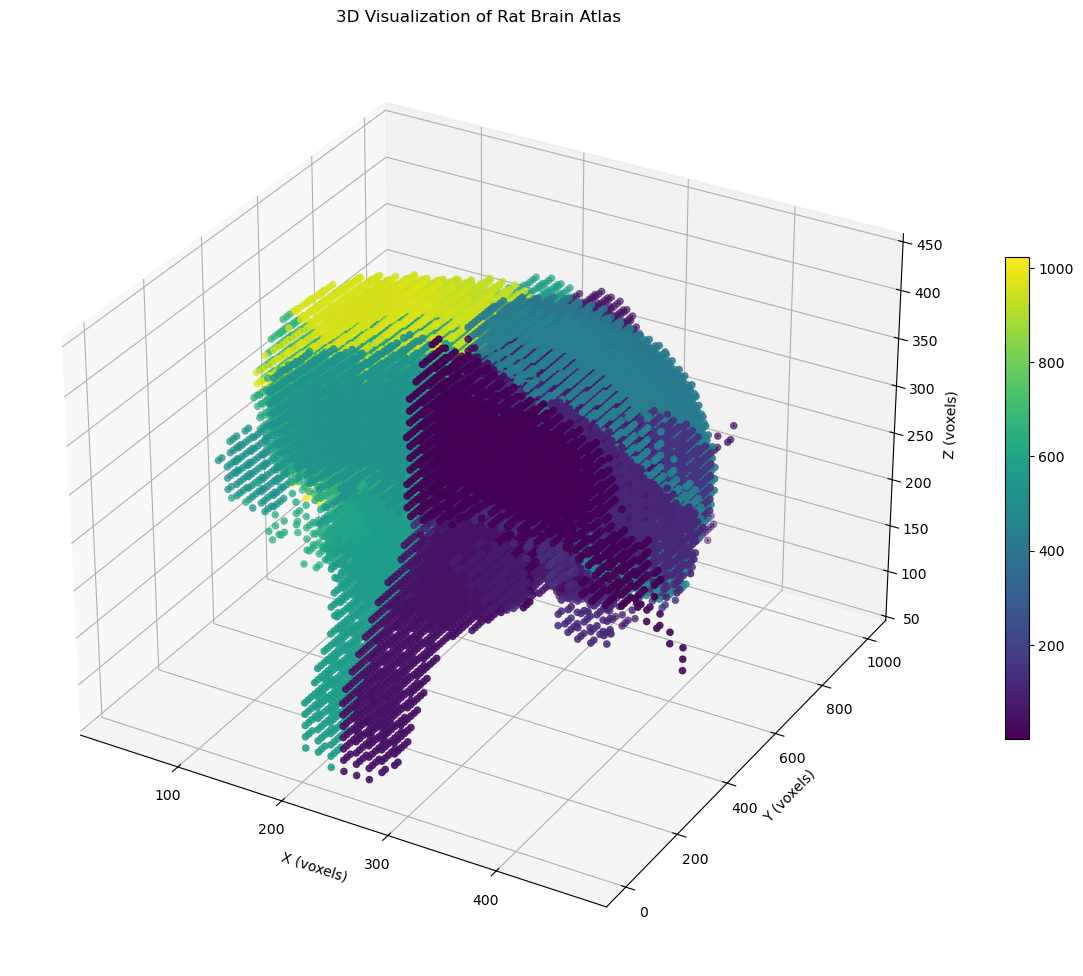

In [11]:
# Create a 3D visualization of the atlas data
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Sample the atlas data to reduce complexity for visualization
# Take every 10th voxel to make it manageable
step = 12
x, y, z = np.meshgrid(
    np.arange(0, atlas_data.shape[0], step),
    np.arange(0, atlas_data.shape[1], step),
    np.arange(0, atlas_data.shape[2], step),
    indexing='ij'
)

# Get non-zero voxels for visualization
atlas_sampled = atlas_data[::step, ::step, ::step]
mask = atlas_sampled > 0

# Plot the brain structure
ax.scatter(x[mask], y[mask], z[mask], 
          c=atlas_sampled[mask], 
          cmap='viridis', 
          alpha=0.6, 
          s=1)

ax.set_xlabel('X (voxels)')
ax.set_ylabel('Y (voxels)')
ax.set_zlabel('Z (voxels)')
ax.set_title('3D Visualization of Rat Brain Atlas')

# Add colorbar
plt.colorbar(ax.scatter(x[mask], y[mask], z[mask], c=atlas_sampled[mask], cmap='viridis'), 
             ax=ax, shrink=0.5, aspect=20)
# Rotate the view angle for better visualization
# ax.view_init(elev=50, azim=20)
plt.tight_layout()
plt.show()

In [164]:
def create_position_matrix(atlas_shape):
    """
    Create a 3D position matrix where each voxel contains its own coordinates.
    Using a single integer that encodes (x,y,z) position.
    """
    x_dim, y_dim, z_dim = atlas_shape
    
    # Create coordinate grids
    x_coords, y_coords, z_coords = np.meshgrid(
        np.arange(x_dim), 
        np.arange(y_dim), 
        np.arange(z_dim), 
        indexing='ij'
    )
    
    # Encode coordinates as a single integer: x + y*x_dim + z*x_dim*y_dim
    position_matrix = (x_coords + 
                      y_coords * x_dim + 
                      z_coords * x_dim * y_dim).astype(np.int64)
    
    return position_matrix

def create_cell_count_matrix(atlas_shape, all_positions, all_counts):
    """
    Create a 3D matrix with cell counts at each voxel position
    """
    import numpy as np
    cell_count_matrix = np.zeros(atlas_shape, dtype=np.float32)
    x_dim, y_dim, z_dim = atlas_shape
    
    for positions, counts in zip(all_positions, all_counts):
        for pos, count in zip(positions, counts):
            # Skip invalid positions (padding areas might have invalid values)
            if pos < 0 or pos >= x_dim * y_dim * z_dim:
                continue
                
            # Decode position
            x, y, z = decode_position(pos, x_dim, y_dim)
            
            # Ensure coordinates are within bounds
            if 0 <= x < x_dim and 0 <= y < y_dim and 0 <= z < z_dim:
                cell_count_matrix[x, y, z] += count
    
    return cell_count_matrix

def create_voxel_referred_matrix(all_positions_referred, atlas_shape):
    """
    Create a voxel-referred matrix from the list of all referred positions.
    """
    import numpy as np
    voxel_referred_matrix = np.zeros(atlas_shape, dtype=np.int64)
    for pos in all_positions_referred:
        
        # Decode position
        x, y, z = decode_position(pos, atlas_shape[0], atlas_shape[1])
        voxel_referred_matrix[x, y, z] = 1
    return voxel_referred_matrix

def decode_position(encoded_pos, x_dim, y_dim):
    """Decode the encoded position back to (x, y, z) coordinates"""
    z = encoded_pos // (x_dim * y_dim)
    remainder = encoded_pos % (x_dim * y_dim)
    y = remainder // x_dim
    x = remainder % x_dim
    return x, y, z
# Create the position matrix
position_matrix = create_position_matrix(atlas_data.shape)
print(f"Position matrix shape: {position_matrix.shape}")
print(f"Position matrix range: {position_matrix.min()} to {position_matrix.max()}")

Position matrix shape: (512, 1024, 512)
Position matrix range: 0 to 268435455


In [165]:
from skimage import measure
from scipy import ndimage

def process_slice_with_neuron_object_counting(curSlice, position_matrix, atlas_data, segmentation_data, min_neuron_size=10):
    """
    Process one slice: extract position info, count neuron objects (not pixels), map back to 3D
    """
    fileName = curSlice['filename']
    Oxyz = curSlice['anchoring'][:3]
    Uxyz = curSlice['anchoring'][3:6]
    Vxyz = curSlice['anchoring'][6:]
    
    # Load segmentation data for this slice
    seg_data = segmentation_data  # Your segmentation mask (neurons = 1)
    height, width = seg_data.shape[:2]
    
    # Extract position slice using the same method as atlas
    position_slice = extract_section(position_matrix, np.array(Oxyz),
                                   np.array(Uxyz), np.array(Vxyz),
                                   output_size=None)
    
    # Reference voxels, we need to track what voxels in the position matrix has been used
    # So that we cancreate a reference matrix with 0 and 1 that shows what voxels are observed.
    position_ref = position_slice.flatten()
    
    # Upsample position slice to match segmentation resolution
    position_slice_upsampled = upsample_and_pad_atlas_slice(
        position_slice, target_dims=(height, width)
    ).astype(np.int64)
    
    # Extract neurons and filter small objects
    neuron_mask = (seg_data == 1)
    
    # Remove small objects (noise)
    from skimage.morphology import remove_small_objects
    neuron_mask_filtered = remove_small_objects(neuron_mask, min_size=min_neuron_size)
    
    # Label individual neuron objects
    labeled_neurons = measure.label(neuron_mask_filtered, connectivity=2)  # 8-connectivity
    num_neurons = labeled_neurons.max()
    
    print(f"Found {num_neurons} neuron objects in {fileName}")
    
    # For each neuron object, find which atlas position it belongs to
    position_neuron_counts = {}
    
    for neuron_id in range(1, num_neurons + 1):
        # Get mask for this specific neuron
        single_neuron_mask = (labeled_neurons == neuron_id)
        
        # Get all position values that this neuron covers
        neuron_positions = position_slice_upsampled[single_neuron_mask.squeeze()]
        
        # Find the most common position (majority vote for this neuron)
        unique_positions, counts = np.unique(neuron_positions, return_counts=True)
        most_common_position = unique_positions[np.argmax(counts)]
        
        # Count this neuron in the corresponding atlas position
        if most_common_position in position_neuron_counts:
            position_neuron_counts[most_common_position] += 1
        else:
            position_neuron_counts[most_common_position] = 1
    
    # Convert to arrays for consistency with previous function
    unique_positions = np.array(list(position_neuron_counts.keys()))
    neuron_counts = np.array(list(position_neuron_counts.values()))

    return unique_positions, neuron_counts, position_ref, position_slice_upsampled.shape, labeled_neurons

# Alternative approach: Assign neurons based on their centroid
def process_slice_with_centroid_assignment(curSlice, position_matrix, atlas_data, segmentation_data, min_neuron_size=10):
    """
    Alternative: Assign each neuron to atlas position based on its centroid
    """
    fileName = curSlice['filename']
    Oxyz = curSlice['anchoring'][:3]
    Uxyz = curSlice['anchoring'][3:6]
    Vxyz = curSlice['anchoring'][6:]
    
    seg_data = segmentation_data
    height, width = seg_data.shape[:2]
    
    # Extract and upsample position slice
    position_slice = extract_section(position_matrix, np.array(Oxyz),
                                   np.array(Uxyz), np.array(Vxyz),
                                   output_size=None)
    position_slice_upsampled = upsample_and_pad_atlas_slice(
        position_slice, target_dims=(height, width)
    ).astype(np.int64)
    
    # Extract and label neurons
    neuron_mask = (seg_data == 1)
    from skimage.morphology import remove_small_objects
    neuron_mask_filtered = remove_small_objects(neuron_mask, min_size=min_neuron_size)
    labeled_neurons = measure.label(neuron_mask_filtered, connectivity=2)
    
    # Get properties of each neuron
    props = measure.regionprops(labeled_neurons)
    
    position_neuron_counts = {}
    
    for prop in props:
        # Get centroid coordinates (row, col)
        centroid_y, centroid_x = prop.centroid
        centroid_y, centroid_x = int(round(centroid_y)), int(round(centroid_x))
        
        # Ensure centroid is within bounds
        centroid_y = max(0, min(centroid_y, height - 1))
        centroid_x = max(0, min(centroid_x, width - 1))
        
        # Get the atlas position at the centroid
        atlas_position = position_slice_upsampled[centroid_y, centroid_x]
        
        # Count this neuron
        if atlas_position in position_neuron_counts:
            position_neuron_counts[atlas_position] += 1
        else:
            position_neuron_counts[atlas_position] = 1
    
    unique_positions = np.array(list(position_neuron_counts.keys()))
    neuron_counts = np.array(list(position_neuron_counts.values()))
    
    print(f"Found {len(props)} neuron objects in {fileName} (centroid method)")
    
    return unique_positions, neuron_counts, position_slice_upsampled.shape, labeled_neurons

In [166]:
def save_as_nifti(data_array, output_path, affine_matrix=None):
    """
    Save atlas array as NIfTI file (skip AFNI conversion)
    """
    import nibabel as nib
    
    # Convert to appropriate data type
    data_int = data_array.astype(np.int16)
    
    # Create affine matrix with proper voxel spacing
    affine = affine_matrix
    print(f"Using affine matrix:\n{affine}")
    print(f"Voxel sizes from affine: x:{affine[0,0]}, y:{affine[1,1]}, z:{affine[2,2]}")
    
    # Create and save NIfTI image
    nii_img = nib.Nifti1Image(data_int, affine)
    nib.save(nii_img, output_path)
    
    print(f"Successfully saved atlas as NIfTI: {output_path}")

In [167]:
def process_all_slices_with_neuron_objects(curSubject, atlas_data, position_matrix, method='majority_vote'):
    """
    Process all slices for a subject and create cell count matrix using neuron object counting
    
    Parameters:
    method: 'majority_vote' or 'centroid'
    """
    import h5py, json
    
    # Load registration data
    registration_json_path = f"../Downsampled_mCherry/{curSubject}/MyResults.json"
    with open(registration_json_path, 'r') as file:
        registration_data = json.load(file)
    registration_slices = registration_data.get("slices", [])
    
    all_positions_neuron = []
    all_positions_referred = []
    all_counts = []
    total_neurons = 0
    
    for i, curSlice in enumerate(registration_slices):
        print(f"Processing slice {i+1}/{len(registration_slices)}: {curSlice['filename']}")
        
        # Load segmentation data for this slice
        slice_name = curSlice['filename'].replace('.png', '')
        h5_path = f"../mCherry_PNG/{curSubject}/{slice_name}_Simple Segmentation.h5"
        
        if os.path.exists(h5_path):
            with h5py.File(h5_path, "r") as f:
                seg_data = f['exported_data'][:]
        else:
            print(f"Segmentation file not found: {h5_path}")
            continue
        
        # Process this slice with neuron object counting
        if method == 'majority_vote':
            positions, counts, position_ref, slice_shape, labeled_neurons = process_slice_with_neuron_object_counting(
                curSlice, position_matrix, atlas_data, seg_data, min_neuron_size=10
            )
        elif method == 'centroid':
            positions, counts, position_ref, slice_shape, labeled_neurons = process_slice_with_centroid_assignment(
                curSlice, position_matrix, atlas_data, seg_data, min_neuron_size=10
            )

        all_positions_neuron.append(positions)
        all_positions_referred.append(position_ref)
        all_counts.append(counts)
        total_neurons += counts.sum()
        
        print(f"  -> {counts.sum()} neurons assigned to {len(positions)} atlas positions")
    
    # Create cell count matrix
    cell_count_matrix = create_cell_count_matrix(atlas_data.shape, all_positions_neuron, all_counts)
    
    # Create voxel-referred matrix
    voxel_referred_matrix = create_voxel_referred_matrix(all_positions_referred, atlas_data.shape)

    print(f"\nSummary for {curSubject}:")
    print(f"Total neurons counted: {total_neurons}")
    print(f"Total neurons in matrix: {cell_count_matrix.sum()}")
    print(f"Non-zero voxels: {np.count_nonzero(cell_count_matrix)}")
    
    return cell_count_matrix, voxel_referred_matrix, all_positions_neuron, all_counts

# Run the processing with neuron object counting
cell_count_matrix, voxel_referred_matrix, all_positions_neuron, all_counts = process_all_slices_with_neuron_objects(
    curSubject, atlas_data, position_matrix, method='majority_vote'  # 'centroid' or 'majority_vote'
)

# Save the results as NIfTI files
output_path = f"../Cell_counting_results/{curSubject}/"
os.makedirs(output_path, exist_ok=True)
save_as_nifti(cell_count_matrix, output_path + "cell_count_matrix.nii.gz", affine_matrix=affine)
save_as_nifti(voxel_referred_matrix, output_path + "voxel_referred_matrix.nii.gz", affine_matrix=affine)

Processing slice 1/30: JW_NOSTIC_VTA15_7-Region 001-channels.png
Found 235 neuron objects in JW_NOSTIC_VTA15_7-Region 001-channels.png
  -> 235 neurons assigned to 233 atlas positions
Processing slice 2/30: JW_NOSTIC_VTA15_6-Region 3-channels.png
Found 432 neuron objects in JW_NOSTIC_VTA15_6-Region 3-channels.png
  -> 432 neurons assigned to 424 atlas positions
Processing slice 3/30: JW_NOSTIC_VTA15_6-Region 4-channels.png
Found 286 neuron objects in JW_NOSTIC_VTA15_6-Region 4-channels.png
  -> 286 neurons assigned to 285 atlas positions
Processing slice 4/30: JW_NOSTIC_VTA15_7-Region 002-channels.png
Found 210 neuron objects in JW_NOSTIC_VTA15_7-Region 002-channels.png
  -> 210 neurons assigned to 209 atlas positions
Processing slice 5/30: JW_NOSTIC_VTA15_6-Region 2-channels.png
Found 450 neuron objects in JW_NOSTIC_VTA15_6-Region 2-channels.png
  -> 450 neurons assigned to 444 atlas positions
Processing slice 6/30: JW_NOSTIC_VTA15_6-Region 1-channels.png
Found 600 neuron objects in J

# Downsample the cell count matrix (sum) and voxel referred matrix (mean)

In [168]:
target_voxel_size = [0.5, 1.0, 0.5] # in mm
current_voxel_size = [affine[0,0], affine[1,1], affine[2,2]]
print(f"Current voxel size: {current_voxel_size} mm")
downsample_factors = [target / current for current, target in zip(current_voxel_size, target_voxel_size)]
print(f"Downsample factors: {downsample_factors}")

Current voxel size: [0.0390625, 0.0390625, 0.0390625] mm
Downsample factors: [12.8, 25.6, 12.8]


In [169]:
# Now downsample both atlas and cell count matrix with the same method
def downsample_matrices(atlas_data, cell_count_matrix, voxel_referred_matrix, downsample_factors):
    """
    Downsample both atlas and cell count matrix using consistent methods
    """
    from scipy.ndimage import zoom
    
    zoom_factors = [1.0 / factor for factor in tuple(map(int, downsample_factors))]
    
    # Downsample atlas (nearest neighbor to preserve labels)
    downsampled_atlas = zoom(atlas_data, zoom_factors, order=0)
    
    # Downsample cell counts (sum to preserve total count)
    # Use order=1 (linear) then round, or use block_reduce with sum
    from skimage.measure import block_reduce
    

    
    downsampled_cells = block_reduce(cell_count_matrix, 
                                   block_size=tuple(map(int, downsample_factors)),
                                   func=np.sum)
    
    downsampled_ref = block_reduce(voxel_referred_matrix, 
                                   block_size=tuple(map(int, downsample_factors)),
                                   func=np.mean)

    # Check if they have the same shape
    if downsampled_cells.shape != downsampled_atlas.shape:
        print("Warning: Downsampled atlas and cell counts matrices have different shapes.")
        print(f"  Atlas shape: {downsampled_atlas.shape}")
        print(f"  Cell counts shape: {downsampled_cells.shape}")

    return downsampled_atlas, downsampled_cells, downsampled_ref


# Downsample both
downsampled_atlas, downsampled_cell_counts, downsampled_voxel_ref = downsample_matrices(
    atlas_data, cell_count_matrix, voxel_referred_matrix, downsample_factors
)

print(f"Downsampled atlas shape: {downsampled_atlas.shape}")
print(f"Downsampled cell counts shape: {downsampled_cell_counts.shape}")
print(f"Downsampled voxel referred shape: {downsampled_voxel_ref.shape}")
print(f"Total neurons preserved: {downsampled_cell_counts.sum()}")

Downsampled atlas shape: (43, 41, 43)
Downsampled cell counts shape: (43, 41, 43)
Downsampled voxel referred shape: (43, 41, 43)
Total neurons preserved: 9396.0


# Post downsampling processing

In [170]:
# Delete the voxels with minor cell counts
minor_cell_count = 5
downsampled_cell_counts[downsampled_cell_counts < minor_cell_count] = 0

In [171]:
# Step 1: Normalize cell counts by coverage to estimate true counts
coverage_threshold = 0.02  # Minimum 10% coverage required
normalized_cell_counts = np.where(
    downsampled_voxel_ref >= coverage_threshold,
    downsampled_cell_counts / downsampled_voxel_ref,  # Divide by coverage
    0
)
target_voxel_size = [0.5, 1.0, 0.5] # in mm
# Step 2: Calculate actual density using fMRI voxel size
voxel_volume_mm3 = np.prod(target_voxel_size)  # [0.5, 1.0, 0.5] = 0.25 mm³
cell_density_matrix = normalized_cell_counts / voxel_volume_mm3

print(f"Voxel volume: {voxel_volume_mm3} mm³")
print(f"Coverage threshold: {coverage_threshold}")
print(f"Voxels with reliable data: {np.sum(downsampled_voxel_ref >= coverage_threshold)}")
print(f"Max normalized density: {cell_density_matrix.max():.2f} cells/mm³")

Voxel volume: 0.25 mm³
Coverage threshold: 0.02
Voxels with reliable data: 11534
Max normalized density: 5488.11 cells/mm³


C:\Users\Wenji\AppData\Local\Temp\ipykernel_24476\1986089322.py:5: RuntimeWarning: divide by zero encountered in divide
  downsampled_cell_counts / downsampled_voxel_ref,  # Divide by coverage
C:\Users\Wenji\AppData\Local\Temp\ipykernel_24476\1986089322.py:5: RuntimeWarning: invalid value encountered in divide
  downsampled_cell_counts / downsampled_voxel_ref,  # Divide by coverage


In [172]:
# Save the downsampled results
output_path = f"../Cell_counting_results/{curSubject}/"
os.makedirs(output_path, exist_ok=True)
affine_downsampled = np.copy(affine)
affine_downsampled[0,0] *= downsample_factors[0]
affine_downsampled[1,1] *= downsample_factors[1]
affine_downsampled[2,2] *= downsample_factors[2]

save_as_nifti(downsampled_atlas, output_path + "atlas_downsampled_asymm.nii.gz", affine_matrix=affine_downsampled)
save_as_nifti(downsampled_cell_counts, output_path + "cell_count_downsampled.nii.gz", affine_matrix=affine_downsampled)
save_as_nifti(downsampled_voxel_ref, output_path + "voxel_referred_downsampled.nii.gz", affine_matrix=affine_downsampled)

save_as_nifti(cell_density_matrix, output_path + "cell_density_downsampled.nii.gz", affine_matrix=affine_downsampled)

Using affine matrix:
[[  0.5         0.          0.         -9.53125  ]
 [  0.          1.          0.        -24.3359375]
 [  0.          0.          0.5        -9.6875   ]
 [  0.          0.          0.          1.       ]]
Voxel sizes from affine: x:0.5, y:1.0, z:0.5
Successfully saved atlas as NIfTI: ../Cell_counting_results/JW_NOSTIC_VTA15/atlas_downsampled_asymm.nii.gz
Using affine matrix:
[[  0.5         0.          0.         -9.53125  ]
 [  0.          1.          0.        -24.3359375]
 [  0.          0.          0.5        -9.6875   ]
 [  0.          0.          0.          1.       ]]
Voxel sizes from affine: x:0.5, y:1.0, z:0.5
Successfully saved atlas as NIfTI: ../Cell_counting_results/JW_NOSTIC_VTA15/cell_count_downsampled.nii.gz
Using affine matrix:
[[  0.5         0.          0.         -9.53125  ]
 [  0.          1.          0.        -24.3359375]
 [  0.          0.          0.5        -9.6875   ]
 [  0.          0.          0.          1.       ]]
Voxel sizes from af

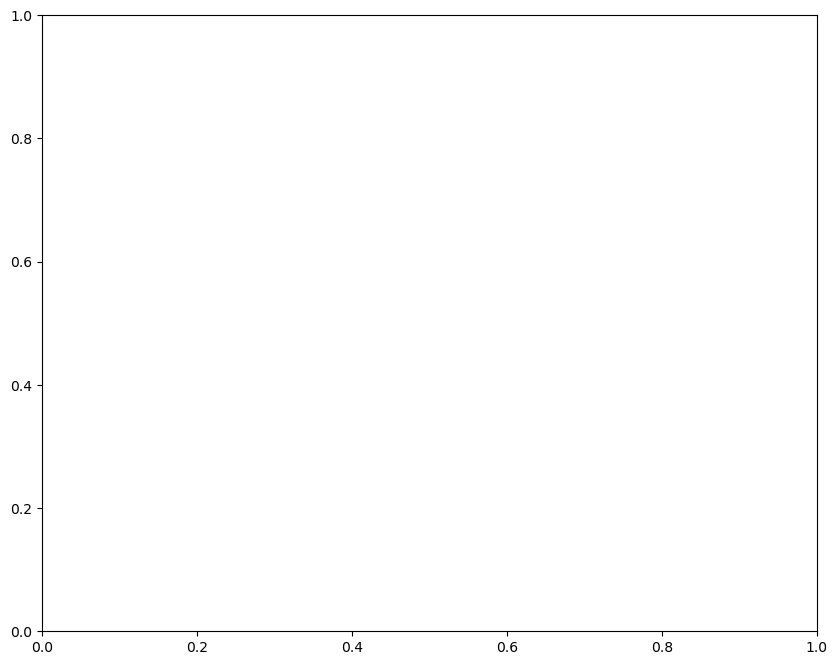

In [173]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

def animate_density_overlay(frame):
    ax.clear()
    # Show atlas in grayscale
    ax.imshow(np.rot90(downsampled_atlas[:, frame, :]), cmap='gray', alpha=0.7)
    # Overlay cell density in red
    density_slice = np.rot90(cell_density_matrix[:, frame, :])
    # Only show non-zero density values
    density_masked = np.ma.masked_where(density_slice == 0, density_slice)
    ax.imshow(density_masked, cmap='Reds', alpha=0.8, interpolation='nearest')
    ax.set_title(f'Cell Density Overlay - Coronal Slice {frame}')
    ax.axis('off')

# Create animation
fig, ax = plt.subplots(figsize=(10, 8))
ani = FuncAnimation(fig, animate_density_overlay, frames=cell_density_matrix.shape[1], 
                   interval=200, repeat=True)

plt.show()

# Save animation
output_path = f"../Cell_counting_results/{curSubject}/"
ani.save(output_path + f"{curSubject}_cell_density_animation_asymm.mp4", writer='ffmpeg', fps=5)

# Post downsampling processing

In [1]:
subject_names = ["JW_NOSTIC2", 
                 "JW_NOSTIC3", 
                 "NOSTIC_VTA4", 
                 "NOSTIC_VTA_N6", 
                 "WT_VTA_N7", # channel
                 "NOSTIC_VTA_N8", 
                 "WT_VTA_N10", # channel
                 "NOSTIC_WT_N11", 
                 "JW_NOSTIC_VTA15", # channel
                 "JW_NOSTIC_VTA16", # channel
                ]

subject_NOT_USED = ["NOSTIC_VTA3", 
                    "JW_NOSTIC_VTA10",]

len(subject_names)

10

In [2]:
input_dir = f"../Cell_counting_results/"


In [3]:
import nibabel as nib
import numpy as np, os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt

# Read cell density matrices from all subjects
density_matrices = []
valid_subjects = []

for subject in subject_names:
    density_path = input_dir + f"{subject}/cell_density_downsampled.nii.gz"
    if os.path.exists(density_path):
        nii = nib.load(density_path)
        density_data = nii.get_fdata()
        density_matrices.append(density_data)
        valid_subjects.append(subject)
        print(f"Loaded {subject}: shape {density_data.shape}, max density {density_data.max():.2f}")
    else:
        print(f"File not found for {subject}: {density_path}")

print(f"\nSuccessfully loaded {len(density_matrices)} subjects")

# Create binary masks for each subject (voxels > 0)
binary_masks = [density > 0 for density in density_matrices]

# Count how many animals have values > 0 at each voxel
overlap_count = np.sum(binary_masks, axis=0)

# Create mask where at least 2 animals have values > 0
min_animals = 2
consensus_mask = overlap_count >= min_animals

# Calculate mean density across subjects for consensus voxels
stacked_densities = np.stack(density_matrices, axis=0)
mean_density = np.mean(stacked_densities, axis=0)
consensus_density = np.where(consensus_mask, mean_density, 0)

print(f"\nConsensus analysis:")
print(f"Total voxels with data from ≥{min_animals} animals: {np.sum(consensus_mask)}")
print(f"Max consensus density: {consensus_density.max():.2f} cells/mm³")



Loaded JW_NOSTIC2: shape (43, 41, 43), max density 2960.00
Loaded JW_NOSTIC3: shape (43, 41, 43), max density 10400.00
Loaded NOSTIC_VTA4: shape (43, 41, 43), max density 5926.00
Loaded NOSTIC_VTA_N6: shape (43, 41, 43), max density 10300.00
Loaded WT_VTA_N7: shape (43, 41, 43), max density 3950.00
Loaded NOSTIC_VTA_N8: shape (43, 41, 43), max density 5739.00
Loaded WT_VTA_N10: shape (43, 41, 43), max density 3826.00
Loaded NOSTIC_WT_N11: shape (43, 41, 43), max density 5830.00
Loaded JW_NOSTIC_VTA15: shape (43, 41, 43), max density 5488.00
Loaded JW_NOSTIC_VTA16: shape (43, 41, 43), max density 3245.00

Successfully loaded 10 subjects

Consensus analysis:
Total voxels with data from ≥2 animals: 816
Max consensus density: 3615.80 cells/mm³


Loaded downsampled atlas from JW_NOSTIC2: shape (43, 41, 43)


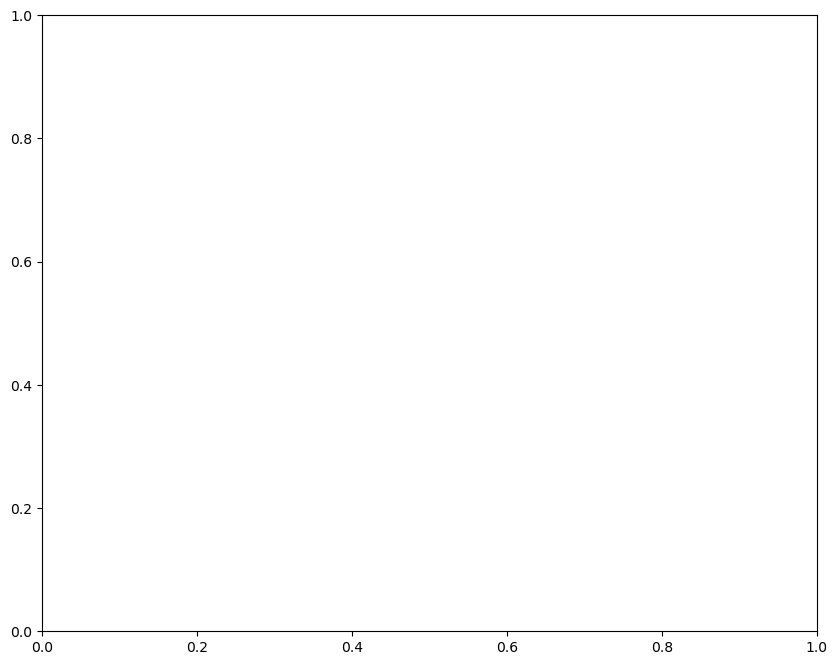

Animation saved as GIF


In [7]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import os

# Load a downsampled atlas for visualization (use the first available subject)
atlas_path = input_dir + f"{valid_subjects[0]}/atlas_downsampled_asymm.nii.gz"
if os.path.exists(atlas_path):
    atlas_nii = nib.load(atlas_path)
    downsampled_atlas = atlas_nii.get_fdata()
    print(f"Loaded downsampled atlas from {valid_subjects[0]}: shape {downsampled_atlas.shape}")
else:
    print(f"Atlas file not found: {atlas_path}")
    # Create a dummy atlas if file doesn't exist
    downsampled_atlas = np.zeros_like(consensus_density)

def animate_consensus_density_overlay(frame):
    ax.clear()
    # Show atlas in grayscale
    ax.imshow(np.rot90(downsampled_atlas[:, frame, :]), cmap='gray', alpha=0.7)
    # Overlay consensus cell density in red
    density_slice = np.rot90(consensus_density[:, frame, :])
    # Only show non-zero density values
    density_masked = np.ma.masked_where(density_slice == 0, density_slice)
    ax.imshow(density_masked, cmap='Reds', alpha=0.8, interpolation='nearest')
    ax.set_title(f'Consensus Cell Density Overlay - Coronal Slice {frame}')
    ax.axis('off')

# Create animation
fig, ax = plt.subplots(figsize=(10, 8))
ani = FuncAnimation(fig, animate_consensus_density_overlay, frames=consensus_density.shape[1], 
                   interval=200, repeat=True)

plt.show()

# Save animation
output_path = f"../Cell_counting_results/"
try:
    # Try to save as GIF with pillow writer (more compatible)
    ani.save(output_path + f"cell_density_animation_asymm_avg.gif", writer='pillow', fps=3)
    print("Animation saved as GIF")
except Exception as e:
    print(f"Could not save animation: {e}")
    # Alternative: save individual frames
